# Initialization

---

In [ ]:
#@title run in case colab is stupid
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [1]:
#@title Imports

%%capture
from torch.utils.data import DataLoader, Subset
import os
from tqdm import tqdm
from torchvision.io import read_image
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image
from torchvision.transforms import Resize

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
#@title MS-SSIM

import warnings
from typing import List, Optional, Tuple, Union

import torch
import torch.nn.functional as F
from torch import Tensor


def _fspecial_gauss_1d(size: int, sigma: float) -> Tensor:
    r"""Create 1-D gauss kernel
    Args:
        size (int): the size of gauss kernel
        sigma (float): sigma of normal distribution
    Returns:
        torch.Tensor: 1D kernel (1 x 1 x size)
    """
    coords = torch.arange(size, dtype=torch.float)
    coords -= size // 2

    g = torch.exp(-(coords ** 2) / (2 * sigma ** 2))
    g /= g.sum()

    return g.unsqueeze(0).unsqueeze(0)


def gaussian_filter(input: Tensor, win: Tensor) -> Tensor:
    r""" Blur input with 1-D kernel
    Args:
        input (torch.Tensor): a batch of tensors to be blurred
        window (torch.Tensor): 1-D gauss kernel
    Returns:
        torch.Tensor: blurred tensors
    """
    assert all([ws == 1 for ws in win.shape[1:-1]]), win.shape
    if len(input.shape) == 4:
        conv = F.conv2d
    elif len(input.shape) == 5:
        conv = F.conv3d
    else:
        raise NotImplementedError(input.shape)

    C = input.shape[1]
    out = input
    for i, s in enumerate(input.shape[2:]):
        if s >= win.shape[-1]:
            out = conv(out, weight=win.transpose(2 + i, -1), stride=1, padding=0, groups=C)
        else:
            warnings.warn(
                f"Skipping Gaussian Smoothing at dimension 2+{i} for input: {input.shape} and win size: {win.shape[-1]}"
            )

    return out


def _ssim(
    X: Tensor,
    Y: Tensor,
    data_range: float,
    win: Tensor,
    size_average: bool = True,
    K: Union[Tuple[float, float], List[float]] = (0.01, 0.03),
    mask: Tensor = None
) -> Tuple[Tensor, Tensor]:
    r""" Calculate ssim index for X and Y

    Args:
        X (torch.Tensor): images
        Y (torch.Tensor): images
        data_range (float or int): value range of input images. (usually 1.0 or 255)
        win (torch.Tensor): 1-D gauss kernel
        size_average (bool, optional): if size_average=True, ssim of all images will be averaged as a scalar

    Returns:
        Tuple[torch.Tensor, torch.Tensor]: ssim results.
    """
    K1, K2 = K
    # batch, channel, [depth,] height, width = X.shape
    compensation = 1.0

    C1 = (K1 * data_range) ** 2
    C2 = (K2 * data_range) ** 2

    win = win.to(X.device, dtype=X.dtype)

    mu1 = gaussian_filter(X, win)
    mu2 = gaussian_filter(Y, win)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1 * mu2

    sigma1_sq = compensation * (gaussian_filter(X * X, win) - mu1_sq)
    sigma2_sq = compensation * (gaussian_filter(Y * Y, win) - mu2_sq)
    sigma12 = compensation * (gaussian_filter(X * Y, win) - mu1_mu2)

    cs_map = (2 * sigma12 + C2) / (sigma1_sq + sigma2_sq + C2)  # set alpha=beta=gamma=1

    if mask is not None:
        resizing = Resize(cs_map.shape[-2:])
        weights = resizing(mask).to(device).float()
        cs_map = 2 * (((cs_map + 1) / 2) ** weights) - 1

    ssim_map = ((2 * mu1_mu2 + C1) / (mu1_sq + mu2_sq + C1)) * cs_map

    ssim_per_channel = torch.flatten(ssim_map, 2).mean(-1)
    cs = torch.flatten(cs_map, 2).mean(-1)
    return ssim_per_channel, cs


def ms_ssim(
    X: Tensor,
    Y: Tensor,
    data_range: float = 255,
    size_average: bool = True,
    win_size: int = 11,
    win_sigma: float = 1.5,
    win: Optional[Tensor] = None,
    weights: Optional[List[float]] = None,
    K: Union[Tuple[float, float], List[float]] = (0.01, 0.03),
    mask: Tensor = None
) -> Tensor:
    r""" interface of ms-ssim
    Args:
        X (torch.Tensor): a batch of images, (N,C,[T,]H,W)
        Y (torch.Tensor): a batch of images, (N,C,[T,]H,W)
        data_range (float or int, optional): value range of input images. (usually 1.0 or 255)
        size_average (bool, optional): if size_average=True, ssim of all images will be averaged as a scalar
        win_size: (int, optional): the size of gauss kernel
        win_sigma: (float, optional): sigma of normal distribution
        win (torch.Tensor, optional): 1-D gauss kernel. if None, a new kernel will be created according to win_size and win_sigma
        weights (list, optional): weights for different levels
        K (list or tuple, optional): scalar constants (K1, K2). Try a larger K2 constant (e.g. 0.4) if you get a negative or NaN results.
    Returns:
        torch.Tensor: ms-ssim results
    """
    if not X.shape == Y.shape:
        raise ValueError(f"Input images should have the same dimensions, but got {X.shape} and {Y.shape}.")

    for d in range(len(X.shape) - 1, 1, -1):
        X = X.squeeze(dim=d)
        Y = Y.squeeze(dim=d)

    #if not X.type() == Y.type():
    #    raise ValueError(f"Input images should have the same dtype, but got {X.type()} and {Y.type()}.")

    if len(X.shape) == 4:
        avg_pool = F.avg_pool2d
    elif len(X.shape) == 5:
        avg_pool = F.avg_pool3d
    else:
        raise ValueError(f"Input images should be 4-d or 5-d tensors, but got {X.shape}")

    if win is not None:  # set win_size
        win_size = win.shape[-1]

    if not (win_size % 2 == 1):
        raise ValueError("Window size should be odd.")

    smaller_side = min(X.shape[-2:])
    assert smaller_side > (win_size - 1) * (
        2 ** 4
    ), "Image size should be larger than %d due to the 4 downsamplings in ms-ssim" % ((win_size - 1) * (2 ** 4))

    if weights is None:
        weights = [0.0448, 0.2856, 0.3001, 0.2363, 0.1333]
    weights_tensor = X.new_tensor(weights)

    if win is None:
        win = _fspecial_gauss_1d(win_size, win_sigma)
        win = win.repeat([X.shape[1]] + [1] * (len(X.shape) - 1))

    levels = weights_tensor.shape[0]
    mcs = []
    for i in range(levels):
        ssim_per_channel, cs = _ssim(X, Y, win=win, data_range=data_range, size_average=False, K=K, mask=mask)
        mask = None

        if i < levels - 1:
            mcs.append(torch.relu(cs))
            padding = [s % 2 for s in X.shape[2:]]
            X = avg_pool(X, kernel_size=2, padding=padding)
            Y = avg_pool(Y, kernel_size=2, padding=padding)

    ssim_per_channel = torch.relu(ssim_per_channel)  # type: ignore  # (batch, channel)
    mcs_and_ssim = torch.stack(mcs + [ssim_per_channel], dim=0)  # (level, batch, channel)
    ms_ssim_val = torch.prod(mcs_and_ssim ** weights_tensor.view(-1, 1, 1), dim=0)

    if size_average:
        return ms_ssim_val.mean()
    else:
        return ms_ssim_val.mean(1)

class MS_SSIM(torch.nn.Module):
    def __init__(
        self,
        data_range: float = 255,
        size_average: bool = True,
        win_size: int = 11,
        win_sigma: float = 1.5,
        channel: int = 3,
        spatial_dims: int = 2,
        weights: Optional[List[float]] = None,
        K: Union[Tuple[float, float], List[float]] = (0.01, 0.03),
    ) -> None:
        r""" class for ms-ssim
        Args:
            data_range (float or int, optional): value range of input images. (usually 1.0 or 255)
            size_average (bool, optional): if size_average=True, ssim of all images will be averaged as a scalar
            win_size: (int, optional): the size of gauss kernel
            win_sigma: (float, optional): sigma of normal distribution
            channel (int, optional): input channels (default: 3)
            weights (list, optional): weights for different levels
            K (list or tuple, optional): scalar constants (K1, K2). Try a larger K2 constant (e.g. 0.4) if you get a negative or NaN results.
        """

        super(MS_SSIM, self).__init__()
        self.win_size = win_size
        self.win = _fspecial_gauss_1d(win_size, win_sigma).repeat([channel, 1] + [1] * spatial_dims)
        self.size_average = size_average
        self.data_range = data_range
        self.weights = weights
        self.K = K

    def forward(self, X: Tensor, Y: Tensor, mask: Tensor = None) -> Tensor:
        return ms_ssim(
            X,
            Y,
            data_range=self.data_range,
            size_average=self.size_average,
            win=self.win,
            weights=self.weights,
            K=self.K,
            mask=mask
        )

In [3]:
#@title LPIPS
%%capture
!git clone https://github.com/richzhang/PerceptualSimilarity
!mv PerceptualSimilarity/lpips/weights weights
!rm -rf PerceptualSimilarity

import torch.nn.init as init
from torch.autograd import Variable
import numpy as np
from collections import namedtuple
from torchvision import models as tv

# def psnr(p0, p1, peak=255.):
#     return 10*np.log10(peak**2/np.mean((1.*p0-1.*p1)**2))

def psnr(p0, p1, peak=255.):
    return 10 * torch.log10(peak ** 2 / torch.mean((p0 - p1) ** 2))


def normalize_tensor(in_feat,eps=1e-10):
    norm_factor = torch.sqrt(torch.sum(in_feat**2,dim=1,keepdim=True))
    return in_feat/(norm_factor+eps)

def l2(p0, p1, range=255.):
    return .5*np.mean((p0 / range - p1 / range)**2)


def tensor2np(tensor_obj):
    # change dimension of a tensor object into a numpy array
    return tensor_obj[0].cpu().float().numpy().transpose((1,2,0))

def np2tensor(np_obj):
     # change dimenion of np array into tensor array
    return torch.Tensor(np_obj[:, :, :, np.newaxis].transpose((3, 2, 0, 1)))

def tensor2tensorlab(image_tensor,to_norm=True,mc_only=False):
    # image tensor to lab tensor
    from skimage import color

    img = tensor2im(image_tensor)
    img_lab = color.rgb2lab(img)
    if(mc_only):
        img_lab[:,:,0] = img_lab[:,:,0]-50
    if(to_norm and not mc_only):
        img_lab[:,:,0] = img_lab[:,:,0]-50
        img_lab = img_lab/100.

    return np2tensor(img_lab)


def tensor2im(image_tensor, imtype=np.uint8, cent=1., factor=255./2.):
    image_numpy = image_tensor[0].cpu().float().numpy()
    image_numpy = (np.transpose(image_numpy, (1, 2, 0)) + cent) * factor
    return image_numpy.astype(imtype)


class squeezenet(torch.nn.Module):
    def __init__(self, requires_grad=False, pretrained=True):
        super(squeezenet, self).__init__()
        pretrained_features = tv.squeezenet1_1(pretrained=pretrained).features
        self.slice1 = torch.nn.Sequential()
        self.slice2 = torch.nn.Sequential()
        self.slice3 = torch.nn.Sequential()
        self.slice4 = torch.nn.Sequential()
        self.slice5 = torch.nn.Sequential()
        self.slice6 = torch.nn.Sequential()
        self.slice7 = torch.nn.Sequential()
        self.N_slices = 7
        for x in range(2):
            self.slice1.add_module(str(x), pretrained_features[x])
        for x in range(2,5):
            self.slice2.add_module(str(x), pretrained_features[x])
        for x in range(5, 8):
            self.slice3.add_module(str(x), pretrained_features[x])
        for x in range(8, 10):
            self.slice4.add_module(str(x), pretrained_features[x])
        for x in range(10, 11):
            self.slice5.add_module(str(x), pretrained_features[x])
        for x in range(11, 12):
            self.slice6.add_module(str(x), pretrained_features[x])
        for x in range(12, 13):
            self.slice7.add_module(str(x), pretrained_features[x])
        if not requires_grad:
            for param in self.parameters():
                param.requires_grad = False

    def forward(self, X):
        h = self.slice1(X)
        h_relu1 = h
        h = self.slice2(h)
        h_relu2 = h
        h = self.slice3(h)
        h_relu3 = h
        h = self.slice4(h)
        h_relu4 = h
        h = self.slice5(h)
        h_relu5 = h
        h = self.slice6(h)
        h_relu6 = h
        h = self.slice7(h)
        h_relu7 = h
        vgg_outputs = namedtuple("SqueezeOutputs", ['relu1','relu2','relu3','relu4','relu5','relu6','relu7'])
        out = vgg_outputs(h_relu1,h_relu2,h_relu3,h_relu4,h_relu5,h_relu6,h_relu7)

        return out


class alexnet(torch.nn.Module):
    def __init__(self, requires_grad=False, pretrained=True):
        super(alexnet, self).__init__()
        alexnet_pretrained_features = tv.alexnet(pretrained=pretrained).features
        self.slice1 = torch.nn.Sequential()
        self.slice2 = torch.nn.Sequential()
        self.slice3 = torch.nn.Sequential()
        self.slice4 = torch.nn.Sequential()
        self.slice5 = torch.nn.Sequential()
        self.N_slices = 5
        for x in range(2):
            self.slice1.add_module(str(x), alexnet_pretrained_features[x])
        for x in range(2, 5):
            self.slice2.add_module(str(x), alexnet_pretrained_features[x])
        for x in range(5, 8):
            self.slice3.add_module(str(x), alexnet_pretrained_features[x])
        for x in range(8, 10):
            self.slice4.add_module(str(x), alexnet_pretrained_features[x])
        for x in range(10, 12):
            self.slice5.add_module(str(x), alexnet_pretrained_features[x])
        if not requires_grad:
            for param in self.parameters():
                param.requires_grad = False

    def forward(self, X):
        h = self.slice1(X)
        h_relu1 = h
        h = self.slice2(h)
        h_relu2 = h
        h = self.slice3(h)
        h_relu3 = h
        h = self.slice4(h)
        h_relu4 = h
        h = self.slice5(h)
        h_relu5 = h
        alexnet_outputs = namedtuple("AlexnetOutputs", ['relu1', 'relu2', 'relu3', 'relu4', 'relu5'])
        out = alexnet_outputs(h_relu1, h_relu2, h_relu3, h_relu4, h_relu5)

        return out

class vgg16(torch.nn.Module):
    def __init__(self, requires_grad=False, pretrained=True):
        super(vgg16, self).__init__()
        vgg_pretrained_features = tv.vgg16(pretrained=pretrained).features
        self.slice1 = torch.nn.Sequential()
        self.slice2 = torch.nn.Sequential()
        self.slice3 = torch.nn.Sequential()
        self.slice4 = torch.nn.Sequential()
        self.slice5 = torch.nn.Sequential()
        self.N_slices = 5
        for x in range(4):
            self.slice1.add_module(str(x), vgg_pretrained_features[x])
        for x in range(4, 9):
            self.slice2.add_module(str(x), vgg_pretrained_features[x])
        for x in range(9, 16):
            self.slice3.add_module(str(x), vgg_pretrained_features[x])
        for x in range(16, 23):
            self.slice4.add_module(str(x), vgg_pretrained_features[x])
        for x in range(23, 30):
            self.slice5.add_module(str(x), vgg_pretrained_features[x])
        if not requires_grad:
            for param in self.parameters():
                param.requires_grad = False

    def forward(self, X):
        h = self.slice1(X)
        h_relu1_2 = h
        h = self.slice2(h)
        h_relu2_2 = h
        h = self.slice3(h)
        h_relu3_3 = h
        h = self.slice4(h)
        h_relu4_3 = h
        h = self.slice5(h)
        h_relu5_3 = h
        vgg_outputs = namedtuple("VggOutputs", ['relu1_2', 'relu2_2', 'relu3_3', 'relu4_3', 'relu5_3'])
        out = vgg_outputs(h_relu1_2, h_relu2_2, h_relu3_3, h_relu4_3, h_relu5_3)

        return out



class resnet(torch.nn.Module):
    def __init__(self, requires_grad=False, pretrained=True, num=18):
        super(resnet, self).__init__()
        if(num==18):
            self.net = tv.resnet18(pretrained=pretrained)
        elif(num==34):
            self.net = tv.resnet34(pretrained=pretrained)
        elif(num==50):
            self.net = tv.resnet50(pretrained=pretrained)
        elif(num==101):
            self.net = tv.resnet101(pretrained=pretrained)
        elif(num==152):
            self.net = tv.resnet152(pretrained=pretrained)
        self.N_slices = 5

        self.conv1 = self.net.conv1
        self.bn1 = self.net.bn1
        self.relu = self.net.relu
        self.maxpool = self.net.maxpool
        self.layer1 = self.net.layer1
        self.layer2 = self.net.layer2
        self.layer3 = self.net.layer3
        self.layer4 = self.net.layer4

    def forward(self, X):
        h = self.conv1(X)
        h = self.bn1(h)
        h = self.relu(h)
        h_relu1 = h
        h = self.maxpool(h)
        h = self.layer1(h)
        h_conv2 = h
        h = self.layer2(h)
        h_conv3 = h
        h = self.layer3(h)
        h_conv4 = h
        h = self.layer4(h)
        h_conv5 = h

        outputs = namedtuple("Outputs", ['relu1','conv2','conv3','conv4','conv5'])
        out = outputs(h_relu1, h_conv2, h_conv3, h_conv4, h_conv5)

        return out

def upsample(in_tens, out_HW=(64,64)): # assumes scale factor is same for H and W
    in_H, in_W = in_tens.shape[2], in_tens.shape[3]
    return nn.Upsample(size=out_HW, mode='bilinear', align_corners=False)(in_tens)

# Learned perceptual metric
class LPIPS(nn.Module):
    def __init__(self, pretrained=True, net='squeeze', version='0.1', lpips=True, spatial=False,
        pnet_rand=False, pnet_tune=False, use_dropout=True, model_path=None, eval_mode=True, verbose=True):
        """ Initializes a perceptual loss torch.nn.Module

        Parameters (default listed first)
        ---------------------------------
        lpips : bool
            [True] use linear layers on top of base/trunk network
            [False] means no linear layers; each layer is averaged together
        pretrained : bool
            This flag controls the linear layers, which are only in effect when lpips=True above
            [True] means linear layers are calibrated with human perceptual judgments
            [False] means linear layers are randomly initialized
        pnet_rand : bool
            [False] means trunk loaded with ImageNet classification weights
            [True] means randomly initialized trunk
        net : str
            ['alex','vgg','squeeze'] are the base/trunk networks available
        version : str
            ['v0.1'] is the default and latest
            ['v0.0'] contained a normalization bug; corresponds to old arxiv v1 (https://arxiv.org/abs/1801.03924v1)
        model_path : 'str'
            [None] is default and loads the pretrained weights from paper https://arxiv.org/abs/1801.03924v1

        The following parameters should only be changed if training the network

        eval_mode : bool
            [True] is for test mode (default)
            [False] is for training mode
        pnet_tune
            [False] keep base/trunk frozen
            [True] tune the base/trunk network
        use_dropout : bool
            [True] to use dropout when training linear layers
            [False] for no dropout when training linear layers
        """

        super(LPIPS, self).__init__()
        if(verbose):
            print('Setting up [%s] perceptual loss: trunk [%s], v[%s], spatial [%s]'%
                ('LPIPS' if lpips else 'baseline', net, version, 'on' if spatial else 'off'))

        self.pnet_type = net
        self.pnet_tune = pnet_tune
        self.pnet_rand = pnet_rand
        self.spatial = spatial
        self.lpips = lpips # false means baseline of just averaging all layers
        self.version = version
        self.scaling_layer = ScalingLayer()

        if(self.pnet_type in ['vgg','vgg16']):
            net_type = vgg16
            self.chns = [64,128,256,512,512]
        elif(self.pnet_type=='alex'):
            net_type = alexnet
            self.chns = [64,192,384,256,256]
        elif(self.pnet_type=='squeeze'):
            net_type = squeezenet
            self.chns = [64,128,256,384,384,512,512]
        self.L = len(self.chns)

        self.net = net_type(pretrained=not self.pnet_rand, requires_grad=self.pnet_tune)

        if(lpips):
            self.lin0 = NetLinLayer(self.chns[0], use_dropout=use_dropout)
            self.lin1 = NetLinLayer(self.chns[1], use_dropout=use_dropout)
            self.lin2 = NetLinLayer(self.chns[2], use_dropout=use_dropout)
            self.lin3 = NetLinLayer(self.chns[3], use_dropout=use_dropout)
            self.lin4 = NetLinLayer(self.chns[4], use_dropout=use_dropout)
            self.lins = [self.lin0,self.lin1,self.lin2,self.lin3,self.lin4]
            if(self.pnet_type=='squeeze'): # 7 layers for squeezenet
                self.lin5 = NetLinLayer(self.chns[5], use_dropout=use_dropout)
                self.lin6 = NetLinLayer(self.chns[6], use_dropout=use_dropout)
                self.lins+=[self.lin5,self.lin6]
            self.lins = nn.ModuleList(self.lins)

            if(pretrained):
                if(model_path is None):
                    import inspect
                    import os
                    model_path = os.path.abspath(os.path.join(inspect.getfile(self.__init__), '..', 'weights/v%s/%s.pth'%(version,net)))

                if(verbose):
                    print('Loading model from: %s'%model_path)
                self.load_state_dict(torch.load(model_path, map_location='cpu'), strict=False)

        if(eval_mode):
            self.eval()

    def forward(self, in0, in1, retPerLayer=False, normalize=False, mask=None):
        return lpips_forward(self, in0, in1, retPerLayer, normalize, mask)

class ScalingLayer(nn.Module):
    def __init__(self):
        super(ScalingLayer, self).__init__()
        self.register_buffer('shift', torch.Tensor([-.030,-.088,-.188])[None,:,None,None])
        self.register_buffer('scale', torch.Tensor([.458,.448,.450])[None,:,None,None])

    def forward(self, inp):
        return (inp - self.shift) / self.scale


class NetLinLayer(nn.Module):
    ''' A single linear layer which does a 1x1 conv '''
    def __init__(self, chn_in, chn_out=1, use_dropout=False):
        super(NetLinLayer, self).__init__()

        layers = [nn.Dropout(),] if(use_dropout) else []
        layers += [nn.Conv2d(chn_in, chn_out, 1, stride=1, padding=0, bias=False),]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

class Dist2LogitLayer(nn.Module):
    ''' takes 2 distances, puts through fc layers, spits out value between [0,1] (if use_sigmoid is True) '''
    def __init__(self, chn_mid=32, use_sigmoid=True):
        super(Dist2LogitLayer, self).__init__()

        layers = [nn.Conv2d(5, chn_mid, 1, stride=1, padding=0, bias=True),]
        layers += [nn.LeakyReLU(0.2,True),]
        layers += [nn.Conv2d(chn_mid, chn_mid, 1, stride=1, padding=0, bias=True),]
        layers += [nn.LeakyReLU(0.2,True),]
        layers += [nn.Conv2d(chn_mid, 1, 1, stride=1, padding=0, bias=True),]
        if(use_sigmoid):
            layers += [nn.Sigmoid(),]
        self.model = nn.Sequential(*layers)

    def forward(self,d0,d1,eps=0.1):
        return self.model.forward(torch.cat((d0,d1,d0-d1,d0/(d1+eps),d1/(d0+eps)),dim=1))

class BCERankingLoss(nn.Module):
    def __init__(self, chn_mid=32):
        super(BCERankingLoss, self).__init__()
        self.net = Dist2LogitLayer(chn_mid=chn_mid)
        # self.parameters = list(self.net.parameters())
        self.loss = torch.nn.BCELoss()

    def forward(self, d0, d1, judge):
        per = (judge+1.)/2.
        self.logit = self.net.forward(d0,d1)
        return self.loss(self.logit, per)


def spatial_average(in_tens, keepdim=True, mask=None):
    if mask is not None:
        resizing = Resize((in_tens.shape[2], in_tens.shape[3]))
        resized_mask = resizing(mask)

        # fig, ax = plt.subplots(1, 3)
        # fig.set_figwidth(15)
        # fig.set_figheight(7)

        # img = ax[0].imshow(in_tens[0, 0].cpu().detach())
        # fig.colorbar(img)
        # img = ax[1].imshow(resized_mask[0, 0].cpu().detach())
        # fig.colorbar(img)

        in_tens = resized_mask * in_tens
        # img = ax[2].imshow(in_tens[0, 0].cpu().detach())
        # fig.colorbar(img)
        # fig.show()
        return torch.sum(in_tens, dim=(2, 3), keepdim=keepdim) / torch.sum(resized_mask, dim=(2, 3))

    return in_tens.mean([2,3],keepdim=keepdim)

def lpips_forward(self, in0, in1, retPerLayer=False, normalize=False, mask=None):
    if normalize: # turn on this flag if input is [0,1] so it can be adjusted to [-1, +1]
        in0 = 2 * in0  - 1
        in1 = 2 * in1  - 1

    # v0.0 - original release had a bug, where input was not scaled
    in0_input, in1_input = (self.scaling_layer(in0), self.scaling_layer(in1)) if self.version=='0.1' else (in0, in1)
    outs0, outs1 = self.net.forward(in0_input), self.net.forward(in1_input)
    feats0, feats1, diffs = {}, {}, {}

    for kk in range(self.L):
        feats0[kk], feats1[kk] = normalize_tensor(outs0[kk]), normalize_tensor(outs1[kk])
        diffs[kk] = (feats0[kk] - feats1[kk]) ** 2

    if(self.lpips):
        if(self.spatial):
            res = [upsample(self.lins[kk](diffs[kk]), out_HW=in0.shape[2:]) for kk in range(self.L)]
        else:
            res = [spatial_average(self.lins[kk](diffs[kk]), keepdim=True, mask=mask) for kk in range(self.L)]
    else:
        if(self.spatial):
            res = [upsample(diffs[kk].sum(dim=1,keepdim=True), out_HW=in0.shape[2:]) for kk in range(self.L)]
        else:
            res = [spatial_average(diffs[kk].sum(dim=1,keepdim=True), keepdim=True, mask=mask) for kk in range(self.L)]

    val = 0
    for l in range(self.L):
        val += res[l]

    if(retPerLayer):
        return (val, res)
    else:
        return val


In [4]:
#@title Fully-Connected Model (from multires_aes)
class CNNAutoencoder(nn.Module):
    def __init__(self, latent_dim):
        super(CNNAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),  # Maintains 218x178
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Reduces to 109x89
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),  # Maintains 109x89
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Reduces to 54x44
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # Maintains 54x44
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Reduces to 27x22
            nn.Flatten(),
            nn.Linear(64 * 27 * 22, latent_dim),
            nn.ReLU()
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64 * 27 * 22),
            nn.ReLU(),
            nn.Unflatten(1, (64, 27, 22)),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # Outputs 54x44
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  # Outputs 109x89
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=4, stride=2, padding=0),  # Outputs 218x178
            nn.Sigmoid()  # Ensures output values are between 0 and 1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


class TwoResAutoEncoder(nn.Module):
    def __init__(self, high_latent_dim, low_latent_dim):
        super(TwoResAutoEncoder, self).__init__()
        self.high_res_autoencoder = CNNAutoencoder(high_latent_dim)
        self.low_res_autoencoder = CNNAutoencoder(low_latent_dim)

    def forward(self, image, fg_mask):
        fg_image = image * fg_mask
        bg_image = image * (~fg_mask)

        fg_output = self.high_res_autoencoder(fg_image)
        bg_output = self.low_res_autoencoder(bg_image)

        return fg_output, bg_output

In [ ]:
#@title Fully Convolutional Model (from multires_aes)


class CNNAutoencoder(nn.Module):
    def __init__(self, latent_dim):
        super(CNNAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.BatchNorm2d(3),
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),       # Maintains 218x178
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Reduces to 109x89

            nn.BatchNorm2d(16),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),      # Maintains 109x89
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Reduces to 54x44

            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),      # Maintains 54x44
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Reduces to 27x22

            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),      # Maintains 27x22
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Reduces to 13x11

            nn.BatchNorm2d(128),
            nn.Conv2d(128, 166, kernel_size=3, stride=1, padding=1),      # Maintains 13x11
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Reduces to 6x5

            nn.BatchNorm2d(166),
            nn.Conv2d(166, 166, kernel_size=(3, 4), stride=1, padding=1),      # Reduces to 6x4
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Reduces to 3x2

            # nn.BatchNorm2d(64),
            # nn.Flatten(),
            # nn.Linear(64 * 27 * 22, latent_dim),
            nn.ReLU()
        )
        # Decoder
        self.decoder = nn.Sequential(
            # nn.Linear(latent_dim, 64 * 27 * 22),
            # nn.GELU(),
            # nn.Unflatten(1, (64, 27, 22)),
            # nn.BatchNorm2d(64),

            nn.ConvTranspose2d(166, 166, kernel_size=3, stride=1, padding=1),   # Maintains 3x2
            nn.ReLU(),
            nn.ConvTranspose2d(166, 166, kernel_size=3, stride=2, padding=1, output_padding=1),  # Outputs 6x4
            nn.BatchNorm2d(166),
            nn.ReLU(),

            nn.ConvTranspose2d(166, 166, kernel_size=3, stride=1, padding=1),   # Maintains 6x4
            nn.ReLU(),
            nn.ConvTranspose2d(166, 128, kernel_size=(3, 5), stride=2, padding=0, output_padding=0),  # Outputs 13x11
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.ConvTranspose2d(128, 128, kernel_size=3, stride=1, padding=1),   # Maintains 13x11
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=(3, 2), stride=2, padding=0, output_padding=0),  # Outputs 27x22
            # Resize((27, 22)),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # Outputs 54x44
            # Resize((54, 44)),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.ConvTranspose2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=0, output_padding=0),  # Outputs 109x89
            nn.BatchNorm2d(16),
            nn.ReLU(),

            nn.ConvTranspose2d(16, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, kernel_size=4, stride=2, padding=1),  # Outputs 218x178
            nn.BatchNorm2d(3),
            nn.Sigmoid()  # Ensures output values are between 0 and 1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


class TwoResAutoEncoder(nn.Module):
    def __init__(self, high_latent_dim, low_latent_dim):
        super(TwoResAutoEncoder, self).__init__()
        self.high_res_autoencoder = CNNAutoencoder(high_latent_dim)
        self.low_res_autoencoder = CNNAutoencoder(low_latent_dim)

    def forward(self, image, fg_mask):
        fg_image = image * fg_mask
        bg_image = image * (~fg_mask)

        fg_output = self.high_res_autoencoder(fg_image)
        bg_output = self.low_res_autoencoder(bg_image)

        return fg_output, bg_output

# Data

---

In [8]:
#@title Upload Data
#@markdown Upload data.zip

%%capture
!unzip data.zip
!mkdir data_processed

data_path = 'data_processed'

def preprocess() -> None:
    i = 0
    for _, _, filenames in os.walk('data'):
        for filename in filenames:
            img = read_image(f'data/{filename}').float()
            img /= 255
            torch.save(img, f'{data_path}/{filename[:filename.find(".")]}.pt')

preprocess()

# Image resizing
img_size = tuple(read_image(f'data/000001.jpg').shape[-2:])
resizer = Resize(img_size)


class ImageFolder(Dataset):
    def __init__(self, data_dir):
        self.data_dir = data_dir

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_name = f'{self.data_dir}/{(6 - len(str(idx + 1))) * "0" + str(idx + 1)}.pt'
        return torch.load(img_name), -1

data = ImageFolder('data_processed')

In [ ]:
#@title Download Data from Web

!pip install --upgrade --no-cache-dir gdown
from torchvision.datasets import CelebA
from torchvision import transforms

target_type = 'attr'
download = True
preprocessing = transforms.Compose([transforms.ToTensor()])
data = CelebA("/content/training/", download=download, split='train', target_type=target_type, transform=preprocessing)


In [ ]:
#@title Generate Bounding Boxes (slow)
import pandas as pd
from PIL import Image
!pip install facenet_pytorch
from facenet_pytorch import MTCNN
import os
from tqdm import tqdm

mtcnn = MTCNN(keep_all=True)
image_dir = 'training/celeba/img_align_celeba'
results = []

no_boxes = []
for i in tqdm(range(1, data_size + 1)):
    file_name = (6 - len(str(i))) * '0' + str(i) + '.jpg'
    file_path = os.path.join(image_dir, file_name)
    image = Image.open(file_path)
    boxes, _ = mtcnn.detect(image)

    if boxes is None:
        no_boxes.append(i)
        results.append([file_name, -1, -1, -1, -1])
    elif len(boxes) > 1:
        box_areas = [(box, (box[2] - box[0]) * (box[3] - box[1])) for box in boxes]
        box = max(box_areas, key=lambda x: x[1])[0]
        box = np.round(box.astype(float)).astype(int)
        results.append([file_name, *box])
    else:
        box = np.round(boxes[0].astype(float)).astype(int)
        results.append([file_name, *box])


# Manually filled bounding boxes
df = pd.DataFrame(results, columns=['filename', 'x1', 'y1', 'x2', 'y2'])
manual_boxes = {199: [35, 70, 145, 180],
                1401: [5, 50, 115, 185],
                2214: [50, 70, 140, 185],
                2432: [55, 70, 140, 185],
                2920: [45, 90, 115, 170],
                3928: [40, 100, 120, 185],
                3946: [40, 60, 115, 210],
                4932: [45, 55, 120, 185],
                5283: [45, 90, 125, 165],
                6010: [60, 95, 120, 200],
                6531: [40, 90, 120, 180],
                7726: [50, 70, 110, 185],
                8287: [40, 95, 110, 185]}
for id in manual_boxes:
    box = manual_boxes[id]
    df.at[id - 1, 'x1'] = box[0]
    df.at[id - 1, 'y1'] = box[1]
    df.at[id - 1, 'x2'] = box[2]
    df.at[id - 1, 'y2'] = box[3]
df.to_csv('bounding_boxes.csv', index=False)

# i = 8287

# file_name = (6 - len(str(i))) * '0' + str(i) + '.jpg'
# file_path = os.path.join(image_dir, file_name)
# image = Image.open(file_path)
# boxes, _ = mtcnn.detect(image)
# image = np.array(image)

# if boxes is not None:
#     for box in boxes:
#         b = box.astype(int)
#         image[b[1]:b[3], b[0]:b[2], :] = 255

# image[95:185, 40:110, :] = 255
# plt.imshow(image)

In [5]:
#@title Upload Bounding Boxes CSV
#@markdown Upload bounding_boxes.csv
import pandas as pd
from torch.utils.data import Dataset

class FaceDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx][0], self.labels[idx]

labels = pd.read_csv('bounding_boxes.csv')
labels = torch.from_numpy(labels[['x1', 'y1', 'x2', 'y2']].values).to(torch.uint8)

In [9]:
batch_size = 25
data_size = 9999
data_full = FaceDataset(data, labels)
subset = Subset(data_full, range(data_size))
dataloader = DataLoader(subset, shuffle=False, batch_size=batch_size)

# Training

---

In [6]:
lpips_alex = LPIPS(net='alex').to(device)
lpips_squeeze = LPIPS(net='squeeze').to(device)
lpips_vgg = LPIPS(net='vgg').to(device)

lpips_alex_loss = lambda x, y: lpips_alex(2 * x - 1, 2 * y - 1)
lpips_squeeze_loss = lambda x, y: lpips_squeeze(2 * x - 1, 2 * y - 1)
lpips_vgg_loss = lambda x, y: lpips_vgg(2 * x - 1, 2 * y - 1)

msssim = MS_SSIM(data_range=1, size_average=True, channel=3)
l2 = nn.MSELoss()
l1 = nn.L1Loss()

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:05<00:00, 44.2MB/s]


Loading model from: /content/weights/v0.1/alex.pth


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/squeezenet1_1-b8a52dc0.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_1-b8a52dc0.pth


Setting up [LPIPS] perceptual loss: trunk [squeeze], v[0.1], spatial [off]


100%|██████████| 4.73M/4.73M [00:00<00:00, 43.7MB/s]
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: /content/weights/v0.1/squeeze.pth
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:04<00:00, 124MB/s]


Loading model from: /content/weights/v0.1/vgg.pth


In [7]:
def loss_function(imgs: torch.Tensor, imgs_reconstruction: torch.Tensor, img_depths: Optional[torch.Tensor] = None) -> torch.Tensor:
    # msssim_loss = 1 - msssim(img, img_reconstruction)
    # l1_loss = l1(img, img_reconstruction) * 3

    # loss = msssim_loss + l1_loss

    return l2(imgs, imgs_reconstruction)

In [ ]:
#@title Calibrating Loss

latent_dims = 1000
num_epochs = 5
learning_rate = 0.01
model = CNNAutoencoder(latent_dims).to(device)

model.train()
for epoch in range(num_epochs):
    for i, (imgs, depth) in enumerate(dataloader):
        imgs = imgs.to(device)
        imgs_reconstruction = model(imgs)
        loss = loss_function(imgs, imgs_reconstruction)

        del imgs, imgs_reconstruction, model
        torch.cuda.empty_cache()

        break
    break

In [10]:
#@title Base Model

latent_dims = 1000
num_epochs = 5


model = CNNAutoencoder(latent_dims).to(device)
optimizer = torch.optim.Adam(model.parameters())

model.train()
for epoch in range(num_epochs):
    for i, (imgs, _) in enumerate(dataloader):
        imgs = imgs.to(device)
        imgs_reconstruction = model(imgs)
        loss = loss_function(imgs, imgs_reconstruction)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        del imgs, imgs_reconstruction
        torch.cuda.empty_cache()

        if i % 20 == 0:
            print(f'{round(loss.item(), 5)}\t\tepoch {epoch}, iter {i}')
model.eval()

0.08547		epoch 0, iter 0
0.09238		epoch 0, iter 20
0.05259		epoch 0, iter 40
0.04592		epoch 0, iter 60
0.03676		epoch 0, iter 80
0.02662		epoch 0, iter 100
0.02919		epoch 0, iter 120
0.02656		epoch 0, iter 140
0.02787		epoch 0, iter 160
0.02798		epoch 0, iter 180
0.02645		epoch 0, iter 200
0.02047		epoch 0, iter 220
0.02063		epoch 0, iter 240
0.01689		epoch 0, iter 260
0.02065		epoch 0, iter 280
0.02082		epoch 0, iter 300
0.02539		epoch 0, iter 320
0.02552		epoch 0, iter 340
0.01979		epoch 0, iter 360
0.01872		epoch 0, iter 380
0.02051		epoch 1, iter 0
0.01909		epoch 1, iter 20
0.01897		epoch 1, iter 40
0.02119		epoch 1, iter 60
0.01849		epoch 1, iter 80
0.01454		epoch 1, iter 100
0.01598		epoch 1, iter 120
0.01617		epoch 1, iter 140
0.01723		epoch 1, iter 160
0.01659		epoch 1, iter 180
0.01574		epoch 1, iter 200
0.01391		epoch 1, iter 220
0.01365		epoch 1, iter 240
0.0121		epoch 1, iter 260
0.01349		epoch 1, iter 280
0.01455		epoch 1, iter 300
0.01683		epoch 1, iter 320
0.01666		epoch

CNNAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=38016, out_features=1000, bias=True)
    (11): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=1000, out_features=38016, bias=True)
    (1): ReLU()
    (2): Unflatten(dim=1, unflattened_size=(64, 27, 22))
    (3): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (4): ReLU()
    (5): ConvTranspo

In [ ]:
torch.save(model.state_dict(), 'no_fc_base_model_l1.pt')
# model.load_state_dict(torch.load('base_model_l2.pt'))

# Model Evaluation

---

In [35]:
#@title Model Evaluation Code

def evaluate_loss(model: nn.Module, amount: int=-1) -> None:
    loss_l2 = 0
    loss_l1 = 0
    loss_alex = 0
    loss_squeeze = 0
    loss_vgg = 0
    loss_msssim = 0
    loss_psnr = 0

    for i, (imgs, _) in enumerate(tqdm(dataloader)):
        if i == amount:
            break
        imgs = imgs.to(device)

        with torch.no_grad():
            imgs_reconstruction = model(imgs)
            loss_l2 += l2(imgs, imgs_reconstruction)
            loss_l1 += l1(imgs, imgs_reconstruction)
            loss_alex += lpips_alex_loss(imgs, imgs_reconstruction)
            loss_squeeze += lpips_squeeze_loss(imgs, imgs_reconstruction)
            loss_vgg += lpips_vgg_loss(imgs, imgs_reconstruction)
            loss_msssim += msssim(imgs, imgs_reconstruction)
            loss_psnr += psnr(imgs, imgs_reconstruction, peak=1)

        del imgs, imgs_reconstruction
        torch.cuda.empty_cache()

    n = max(len(dataloader), amount)
    process = lambda x: round(x.item() / n, 5)

    loss_l2 = process(loss_l2)
    loss_l1 = process(loss_l1)
    loss_alex = process(torch.mean(loss_alex))
    loss_squeeze = process(torch.mean(loss_squeeze))
    loss_vgg = process(torch.mean(loss_vgg))
    loss_msssim = process(loss_msssim)
    loss_psnr = process(loss_psnr)

    print(f"MODEL EVALUATION")
    print(f"----------------")
    print(f"{loss_l2}\tL2")
    print(f"{loss_l1}\tL1")
    print(f"{loss_alex}\tLPIPS-Alex")
    print(f"{loss_squeeze}\tLPIPS-Squeeze")
    print(f"{loss_vgg}\tLPIPS-VGG")
    print(f"{loss_msssim}\tMS-SSIM")
    print(f"{loss_psnr}\tPSNR")


def plot_examples(model: nn.Module, amount: int=5, offset: int=0) -> None:
    for i, (imgs, _) in enumerate(dataloader):
        while i < offset:
            continue
        imgs = imgs.to(device)
        with torch.no_grad():
            imgs_reconstruction = model(imgs)

        fig, ax = plt.subplots(2, amount)
        fig.set_figwidth(30)
        fig.set_figheight(15)

        for k in range(amount):
            ax[0, k].imshow(to_pil_image(imgs[k]))
            ax[1, k].imshow(to_pil_image(imgs_reconstruction[k]))
            ax[0, k].axis('off')
            ax[1, k].axis('off')

        del imgs, imgs_reconstruction
        torch.cuda.empty_cache()
        break


def evaluate_loss_rounding(model: nn.Module, base_model: bool = True, amount: int=-1) -> None:
    loss_l2 = 0
    loss_l1 = 0
    loss_alex = 0
    loss_squeeze = 0
    loss_vgg = 0
    loss_msssim = 0
    loss_psnr = 0

    for i, (imgs, _) in enumerate(tqdm(dataloader)):
        if i == amount:
            break
        imgs = imgs.to(device)

        with torch.no_grad():
            if base_model:
                encoded = model.encoder(imgs)
                imgs_reconstruction = model.decoder(torch.round(encoded))
            else:
                raise NotImplementedError()

            loss_l2 += l2(imgs_reconstruction, imgs)
            loss_l1 += l1(imgs_reconstruction, imgs)
            loss_alex += lpips_alex_loss(imgs_reconstruction, imgs)
            loss_squeeze += lpips_squeeze_loss(imgs_reconstruction, imgs)
            loss_vgg += lpips_vgg_loss(imgs_reconstruction, imgs)
            loss_msssim += msssim(imgs_reconstruction, imgs)
            loss_psnr += psnr(imgs_reconstruction, imgs, peak=1)

        del imgs, x, r, encoded
        torch.cuda.empty_cache()

    n = max(len(dataloader), amount)
    process = lambda x: round(x.item() / n, 5)

    loss_l2 = process(loss_l2)
    loss_l1 = process(loss_l1)
    loss_alex = process(torch.mean(loss_alex))
    loss_squeeze = process(torch.mean(loss_squeeze))
    loss_vgg = process(torch.mean(loss_vgg))
    loss_msssim = process(loss_msssim)
    loss_psnr = process(loss_psnr)

    print(f"MODEL EVALUATION")
    print(f"----------------")
    print(f"{loss_l2}\tL2")
    print(f"{loss_l1}\tL1")
    print(f"{loss_alex}\tLPIPS-Alex")
    print(f"{loss_squeeze}\tLPIPS-Squeeze")
    print(f"{loss_vgg}\tLPIPS-VGG")
    print(f"{loss_msssim}\tMS-SSIM")
    print(f"{loss_psnr}\tPSNR")


def plot_examples_rounding(model: nn.Module, base_model: bool=True, amount: int=5, offset: int=0) -> None:
    for i, (imgs, _) in enumerate(dataloader):
        while i < offset:
            continue
        imgs = imgs.to(device)
        with torch.no_grad():
            if base_model:
                encoded = model.encoder(imgs)
                x = model.decoder(encoded)
                r = model.decoder(torch.round(encoded))
            else:
                raise NotImplementedError()

        fig, ax = plt.subplots(2, amount)
        fig.set_figwidth(30)
        fig.set_figheight(15)

        for k in range(amount):
            with torch.no_grad():
                diff = torch.mean(torch.abs(r[k] - x[k]), dim=0).cpu().detach()
            ax[0, k].imshow(to_pil_image(r[k]))
            ax[1, k].imshow(diff)
            ax[0, k].axis('off')
            ax[1, k].axis('off')

        del imgs, x, r, encoded
        torch.cuda.empty_cache()
        break

def plot_latent_space(model: nn.Module, base_model: bool=True, amount: int=3, offset: int=0, shape: tuple[int, int]=(40, 25)) -> None:
    for i, (imgs, _) in enumerate(dataloader):
        while i < offset:
            continue
        imgs = imgs.to(device)
        with torch.no_grad():
            if base_model:
                encoded = model.encoder(imgs)
            else:
                raise NotImplementedError()

        fig, ax = plt.subplots(1, amount)
        fig.set_figwidth(30)
        fig.set_figheight(12)

        for k in range(amount):
            img = ax[k].imshow(encoded[k].cpu().detach().reshape(shape))
            fig.colorbar(img)
            ax[k].axis('off')

        del imgs, encoded
        torch.cuda.empty_cache()
        break

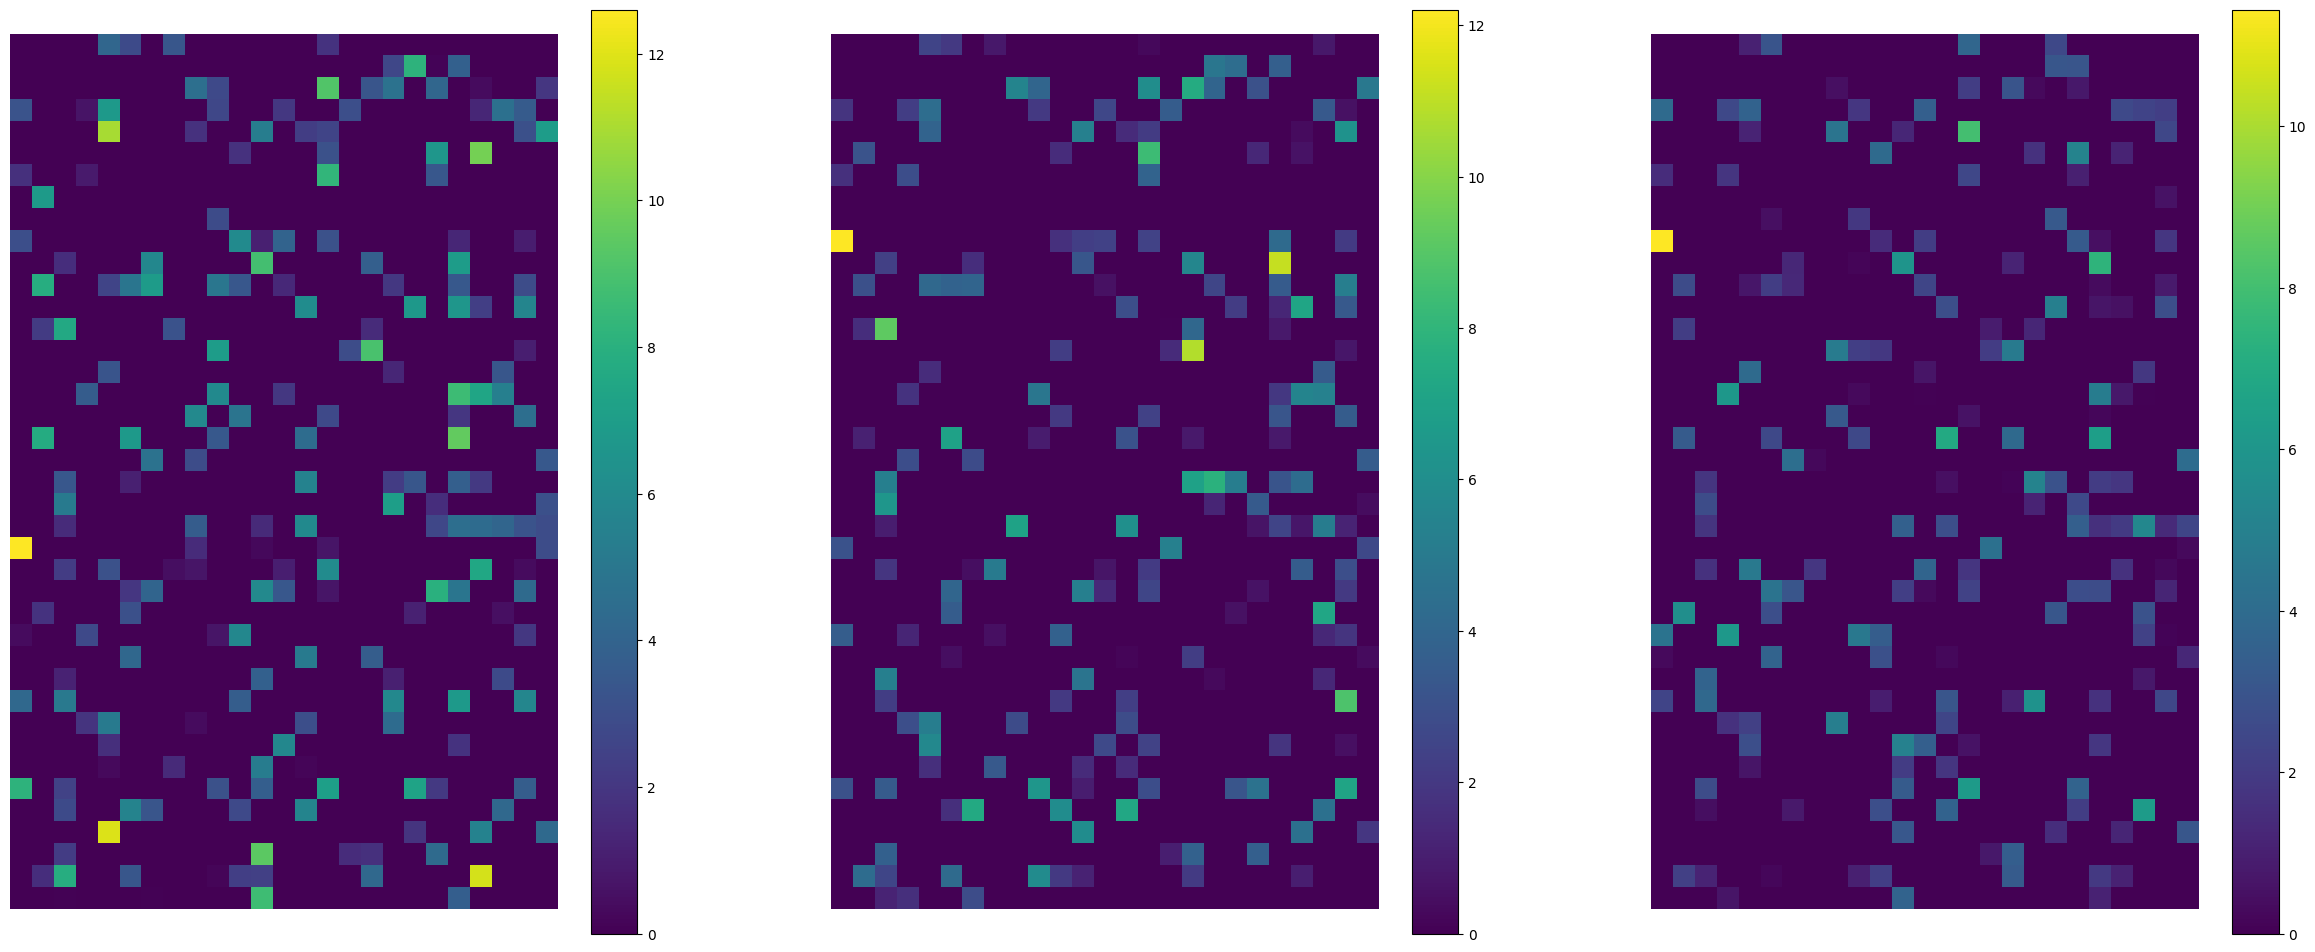

In [36]:
plot_latent_space(model)

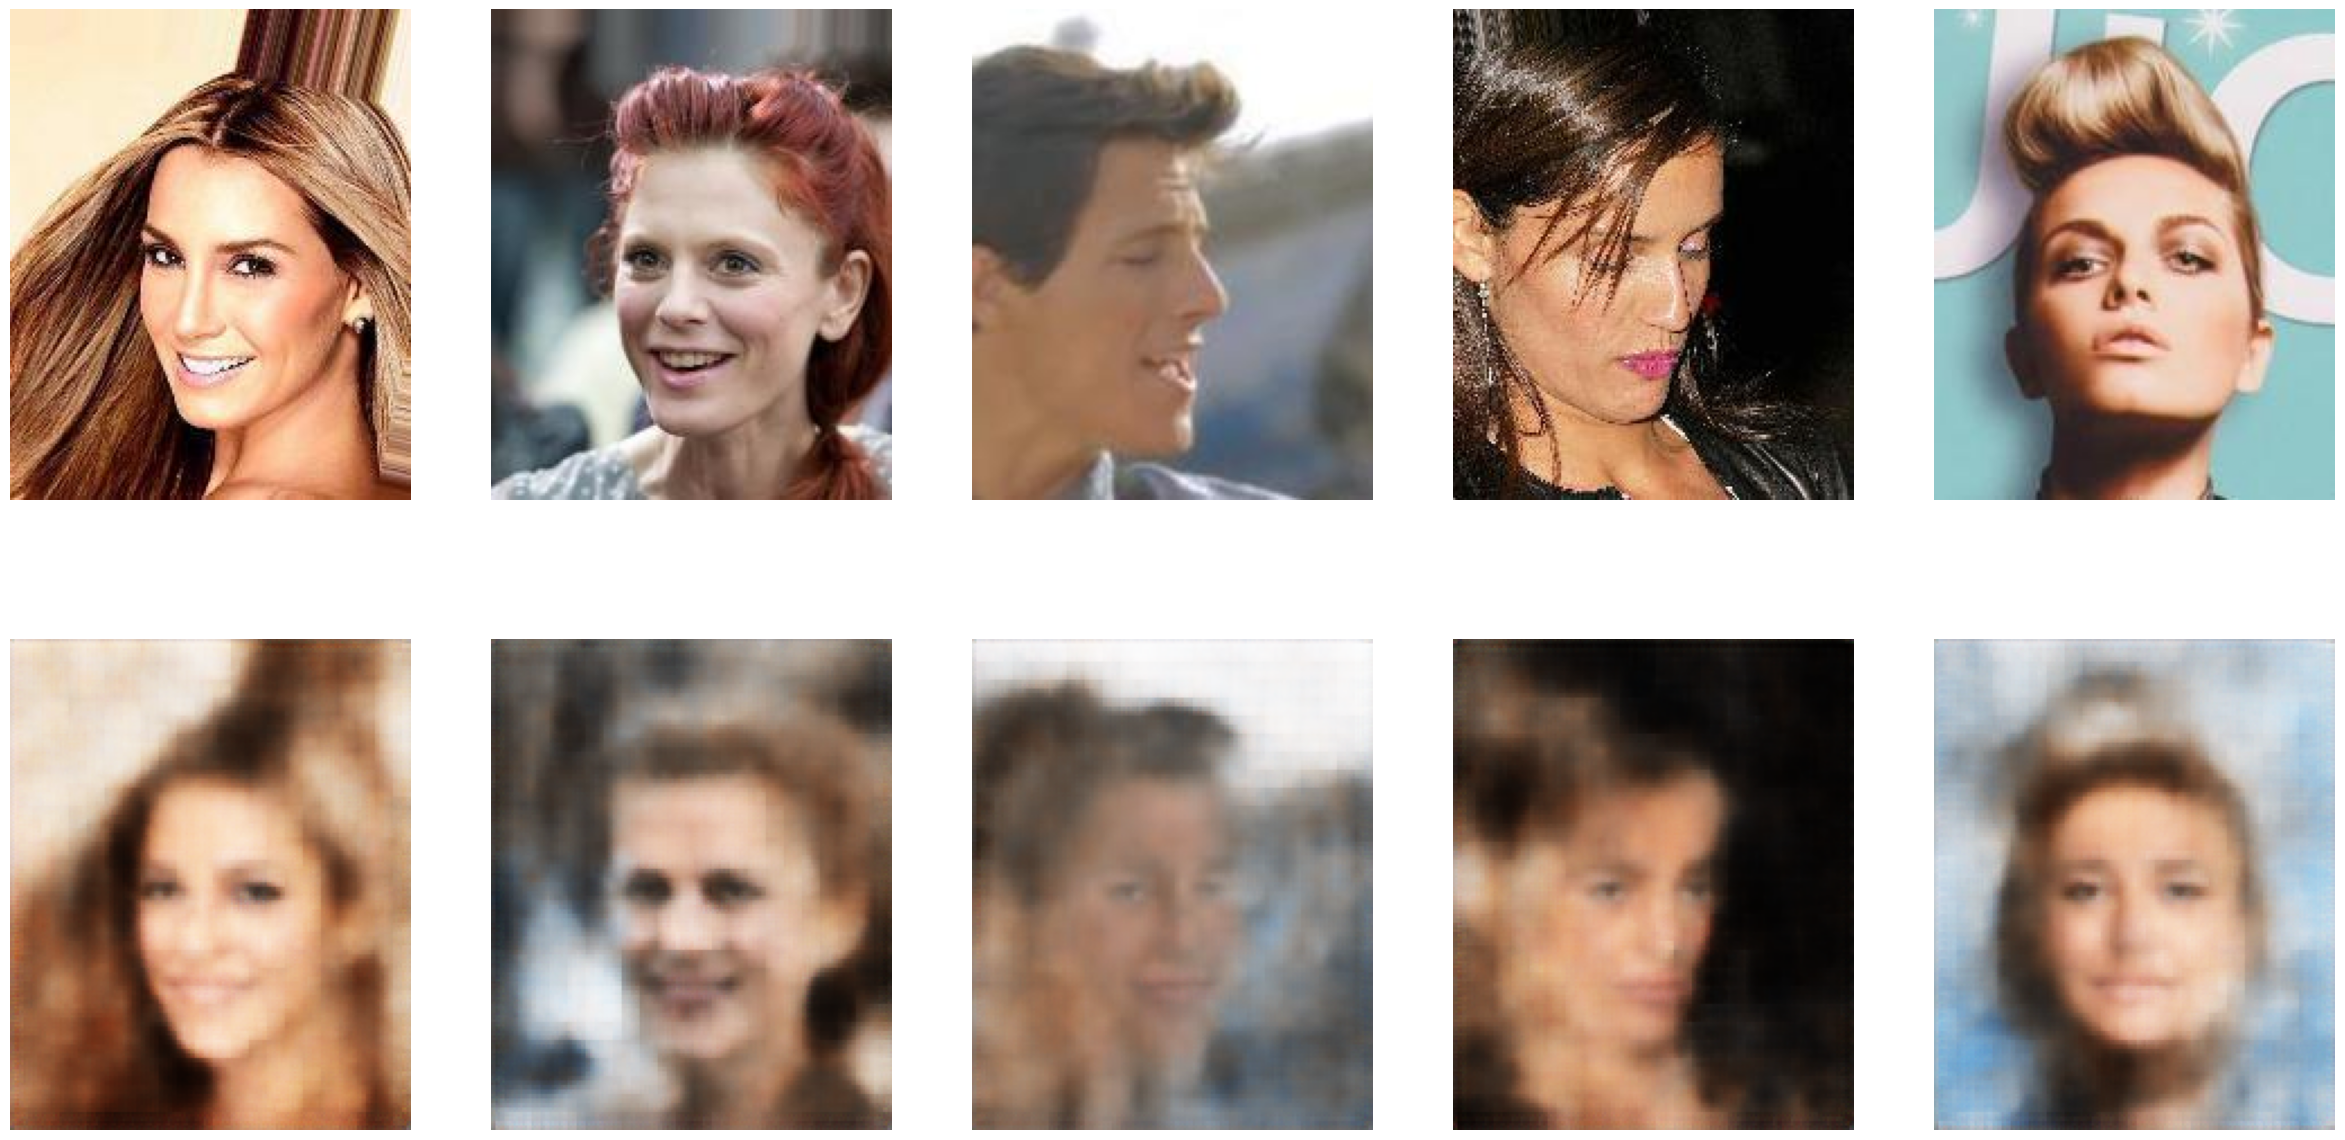

In [ ]:
plot_examples(model, amount=5, offset=0)
plot_examples_rounding(model, base_model=True, amount=5, offset=0)

In [ ]:
evaluate_loss(model, amount=50)
evaluate_loss_rounding(model, amount=50)

 12%|█▎        | 50/400 [00:17<02:01,  2.89it/s]


MODEL EVALUATION
----------------
0.00403	L2
0.01597	L1
0.06238	LPIPS-Alex
0.0606	LPIPS-Squeeze
0.07431	LPIPS-VGG
0.07568	MS-SSIM
1.86655	PSNR


 12%|█▎        | 50/400 [00:17<02:03,  2.84it/s]

MODEL EVALUATION
----------------
0.00032	L2
0.00443	L1
0.00536	LPIPS-Alex
0.00481	LPIPS-Squeeze
0.01043	LPIPS-VGG
0.1195	MS-SSIM
3.23512	PSNR
